# Variational Autoencoder-Based Outlier Detection

In [1]:
import sys
print(f"Python path: {sys.executable}")
print(f"Looking for packages in these directories: {sys.path}")

import torch
# Pytorch check
print(f"Is CUDA working? {torch.cuda.is_available()}")
print(f"Using this GPU: {torch.cuda.get_device_name(0)}")

import os
import random

import h5py
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import sympy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

Python path: /users/jzhu118/.conda/envs/GEDI/bin/python
Looking for packages in these directories: ['/oscar/scratch/jzhu118/GEDI_Outlier_Detection_OSCAR', '/users/jzhu118/.conda/envs/GEDI/lib/python313.zip', '/users/jzhu118/.conda/envs/GEDI/lib/python3.13', '/users/jzhu118/.conda/envs/GEDI/lib/python3.13/lib-dynload', '', '/users/jzhu118/.local/lib/python3.13/site-packages', '/users/jzhu118/.conda/envs/GEDI/lib/python3.13/site-packages']
Is CUDA working? True
Using this GPU: Quadro RTX 6000


## Step 1: Load the data

In [2]:
from torch.utils.data import Dataset, DataLoader

'''Load df from a .parquet file'''

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device is {device}")

df = pd.read_parquet('input_standard_scaled.parquet', engine='pyarrow')
print(f'Dataset has shape {df.shape}')

# 3) Shuffle data (optional, but often useful for large sets)
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
print("Data shuffled")

# 4) Train-test split (for validation or test purposes)
#    Let's hold out 30% for a test set
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
print("Train-test-split")

train_data = train_df.to_numpy().astype(np.float32)
test_data = test_df.to_numpy().astype(np.float32)
print("Data converted to NumPy arrays and float32 for Pytorch")

print(f"train_data shape: {train_data.shape}")
print(f"test_data shape: {test_data.shape}")

Device is cuda
Dataset has shape (11607187, 85)
Data shuffled
Train-test-split
Data converted to NumPy arrays and float32 for Pytorch
train_data shape: (8125030, 85)
test_data shape: (3482157, 85)


In [3]:
###########################
# Tunable Hyperparameters #
###########################
# Data & Training
batch_size    = 2048         # Number of samples per batch
num_epochs    = 10            # Number of training epochs

# Model Architecture
input_dim     = 85           # Dimensionality of input features
latent_dim    = 16           # Dimensionality of the latent space
dropout_p     = 0.05          # Dropout probability in encoder layers

# Optimization
lr            = 1e-3         # Learning rate for Adam optimizer
weight_decay  = 1e-8         # Weight decay (L2 regularization)

# Loss weighting
kl_weight     = 0.2         # Weight for the KL divergence term in the loss
print("All hyperparameters set!")

All hyperparameters set!


In [5]:
#######################
# Dataset Preparation #
#######################
# Assume that train_data and test_data are already processed NumPy arrays of shape (N, 85).

class TabularDataset(Dataset):
    def __init__(self, data_array):
        # data_array: NumPy array shape (N, 85)
        self.X = data_array
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        # Return a single sample as a float tensor
        sample = self.X[idx, :]
        return torch.from_numpy(sample).float()

# Instantiate Datasets
train_dataset = TabularDataset(train_data)
test_dataset  = TabularDataset(test_data)

# Create DataLoaders
print(f"Using batch size {batch_size}")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
print("Data processing complete")

Using batch size 2048
Data processing complete


## Step 2: Set up the autoencoder
The autoencoder has 5 encoding layers and 5 decoding layers. All activation layers between these layers are ReLU.

In [6]:
'''
We've determined empirically that there are 85 relevant features in the input data (after dropping invalid and non-numeric features like ShotNum)
'''
####################
# VAE Model Design #
####################
class VAE(nn.Module):
    def __init__(self, input_dim=85, latent_dim=16, dropout_p=0.2):
        super(VAE, self).__init__()
        
        # Encoder: maps input -> hidden layers -> latent parameters (mu and logvar)
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)
        self.dropout = nn.Dropout(dropout_p)
        
        # Decoder: maps latent vector -> hidden layers -> reconstruction of input
        self.decoder_fc1 = nn.Linear(latent_dim, 32)
        self.decoder_fc2 = nn.Linear(32, 64)
        self.decoder_fc3 = nn.Linear(64, input_dim)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = self.dropout(h)
        h = F.relu(self.fc2(h))
        h = self.dropout(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        # Compute standard deviation and sample epsilon from a standard normal distribution.
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = F.relu(self.decoder_fc1(z))
        h = F.relu(self.decoder_fc2(h))
        recon = self.decoder_fc3(h)  # No activation; raw linear output
        return recon
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

## Step 3: Set up learning and loss function
We will define our loss function to be mean-squared error (MSE) and use the Adam optimizer.

In [7]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = VAE(input_dim=input_dim, latent_dim=latent_dim, dropout_p=dropout_p)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model.to(device)

############################
# Loss Function and Optimizer
############################
criterion = nn.MSELoss()  # Reconstruction loss (MSE)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
print("Model, loss function, optimizer defined.")

Let's use 2 GPUs!
Model, loss function, optimizer defined.


## Step 4: Main training loop
The loss of each epoch is captured in a Pandas dataframe *loss_df* for convenient graphing.

In [8]:
##################
# Training Loop  #
##################
loss_df = []
print("Starting VAE training...\n")
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    counter = 0
    for batch_data in train_loader:
        batch_data = batch_data.to(device)
        optimizer.zero_grad()
        
        # Forward pass through the VAE
        recon, mu, logvar = model(batch_data)
        
        # Reconstruction loss
        recon_loss = criterion(recon, batch_data)
        
        # KL Divergence loss (averaged over batch)
        kl_loss = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
        
        # Total loss: reconstruction loss + (weighted) KL divergence
        loss = recon_loss + kl_weight * kl_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # <-- Add this line (adjust max_norm as needed)
        optimizer.step()
        
        epoch_loss += loss.item()

        counter += 1
        # print(f"Completed batch {counter} in epoch {epoch + 1}!")
    
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")
    loss_df.append({'epoch': epoch + 1, 'loss': avg_loss})

loss_df = pd.DataFrame(loss_df)
loss_df.index = loss_df['epoch']
loss_df = loss_df.drop(columns=['epoch'])
print("\nDone training\n")


Starting VAE training...



/users/jzhu118/.conda/envs/GEDI/lib/python3.13/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return F.linear(input, self.weight, self.bias)


Epoch [1/10], Loss: 0.960486
Epoch [2/10], Loss: 1.672445
Epoch [3/10], Loss: 0.959181
Epoch [4/10], Loss: 0.959174
Epoch [5/10], Loss: 0.959151
Epoch [6/10], Loss: 0.959163
Epoch [7/10], Loss: 0.959161
Epoch [8/10], Loss: 0.959160
Epoch [9/10], Loss: 0.959171
Epoch [10/10], Loss: 0.959153

Done training



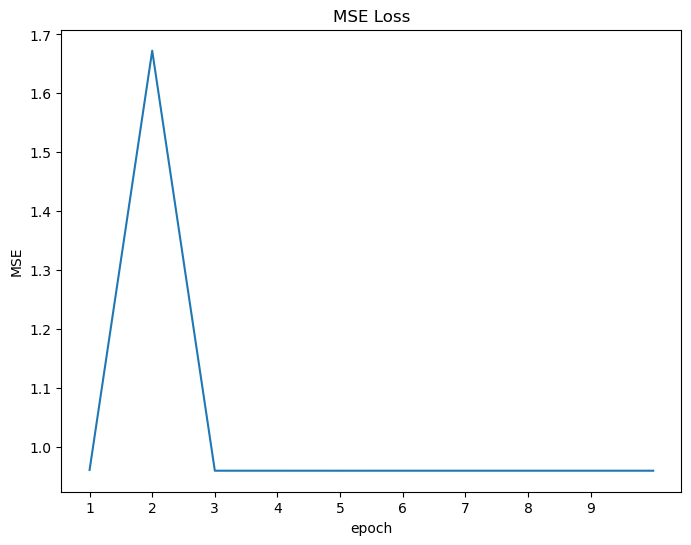

In [9]:
plt.figure(figsize=(8,6))
ax = loss_df['loss'].plot(kind='line', title='MSE Loss', ylabel='MSE')
_ = ax.set_xticks(list(range(1, num_epochs, 1)))

## Step 5: Compute reconstruction error and determine the outlier threshold

In [10]:
######################################
# Evaluation: Compute Reconstruction Error
######################################
# For outlier detection we compute the per-sample MSE (reconstruction error).
model.eval()
train_losses = []
with torch.no_grad():
    for batch_data in train_loader:
        batch_data = batch_data.to(device)
        recon, mu, logvar = model(batch_data)
        # Compute MSE per sample across features
        mse = torch.mean((recon - batch_data)**2, dim=1)
        train_losses.append(mse.cpu().numpy())

train_losses = np.concatenate(train_losses, axis=0)
print("Train losses shape:", train_losses.shape)
mean_loss = np.mean(train_losses)
std_loss  = np.std(train_losses)
print(f"Train MSE mean: {mean_loss:.6f}, std: {std_loss:.6f}")

Train losses shape: (8124416,)
Train MSE mean: 0.959167, std: 36.035976


In [11]:
# Evaluate on test set
test_losses = []
with torch.no_grad():
    for batch_data in test_loader:
        batch_data = batch_data.to(device)
        recon, mu, logvar = model(batch_data)
        mse = torch.mean((recon - batch_data)**2, dim=1)
        test_losses.append(mse.cpu().numpy())
test_losses = np.concatenate(test_losses, axis=0)
print("Test losses shape:", test_losses.shape)

Test losses shape: (3482157,)


In [14]:
#########################
# Outlier Detection
#########################
# Define an outlier threshold based on training error statistics.
# (For example, label samples with reconstruction error > mean + 3*std as outliers.)
# Use the 99th percentile as the threshold for outlier detection
threshold = np.percentile(train_losses, 99)
print(f"Outlier threshold (99th percentile): {threshold:.6f}")

# Label test samples: 1 for outlier, 0 for inlier.
outliers_test = (test_losses > threshold).astype(int)
outlier_fraction = np.mean(outliers_test)
print(f"Outlier fraction in test set: {outlier_fraction:.2%}")

Outlier threshold (99th percentile): 6.312209
Outlier fraction in test set: 1.01%


RH 50 index is 1, RH 95 index is 4


/users/jzhu118/.local/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


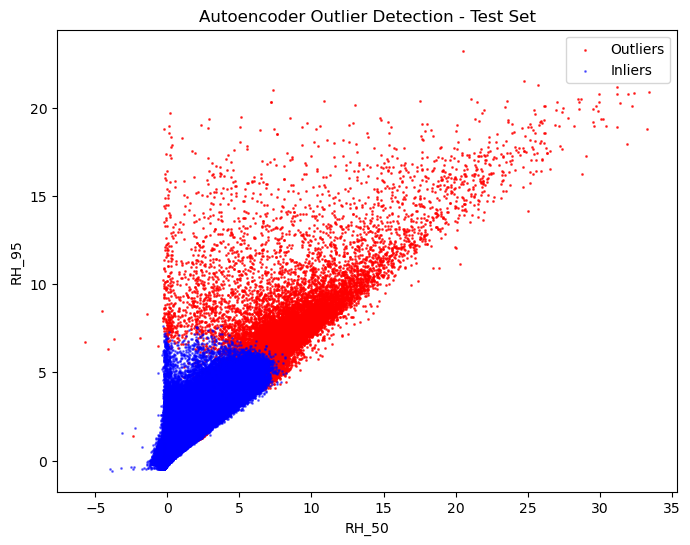

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose outliers_test is 1 for outlier, 0 for inlier
# test_data is shape (N_test, 92) (float32 or float64)
# We pick columns that correspond to RH_50 and RH_95 in the test set
rh_50_idx = test_df.columns.get_loc('RH_50')
rh_95_idx = test_df.columns.get_loc('RH_95')
print(f'RH 50 index is {rh_50_idx}, RH 95 index is {rh_95_idx}')

# Separate inliers vs outliers
inliers_mask  = (outliers_test == 0)
outliers_mask = (outliers_test == 1)

plt.figure(figsize=(8,6))

# Plot outliers
plt.scatter(
    test_data[outliers_mask, rh_50_idx],
    test_data[outliers_mask, rh_95_idx],
    color='red', s=1, alpha=0.7, label='Outliers'
)

# Plot inliers
plt.scatter(
    test_data[inliers_mask, rh_50_idx],
    test_data[inliers_mask, rh_95_idx],
    color='blue', s=1, alpha=0.5, label='Inliers'
)

plt.xlabel("RH_50")   # Or the actual name of the feature
plt.ylabel("RH_95")   # Or the actual name of the feature
plt.title("Variational Autoencoder Outlier Detection - Test Set")
plt.legend()
plt.show()
